In [1]:
import sys
sys.path.append('./../')
import src
from src import proyecto_1
from src.utils import utils
import pandas as pd
import numpy as np
import os
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from numpy import savetxt
from matplotlib import pyplot

In [2]:
proyecto_1.main()

./../src/pipelines/feature_engineering.py:14: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.inputs = df.drop(['latitud', 'longitud', 'codigo_cierre','fecha_creacion','incidente_c4'], axis=1)


In [3]:
c5_inputs = utils.load_df('output/fe_df.pkl')

In [4]:
c5_inputs.nunique()

dia_semana               7
delegacion_inicio       16
clas_con_f_alarma        4
tipo_entrada             9
mes                     12
label                    2
año_creacion             8
sin_time             76786
cos_time             77399
dtype: int64

### Definimos los nombres de las variables que vamos a usar

In [5]:
names=np.array(c5_inputs.delegacion_inicio.unique())
names=np.append(names,np.array(c5_inputs.clas_con_f_alarma.unique()))
names=np.append(names,np.array(c5_inputs.tipo_entrada.unique()))
names=np.append(names,np.array(['año','mes','sin_time', 'cos_time']))

### Definimos los transformadores de las variables categoricas y la imputacion de datos con la media de coseno y seno del tiempo

In [6]:
transformers = [('one_hot', OneHotEncoder(), [ 'delegacion_inicio','clas_con_f_alarma','tipo_entrada']),
               ('año', SimpleImputer(strategy="mean"), ['año_creacion']),
               ('mes', SimpleImputer(strategy="mean"), ['mes']),
               ('impute_sin_time', SimpleImputer(strategy="median"), ['sin_time']),
               ('impute_cos_time', SimpleImputer(strategy="median"), ['cos_time'])]

In [7]:
col_trans = ColumnTransformer(transformers, remainder="drop", n_jobs=-1, verbose=True)
#col_trans = ColumnTransformer(transformers, n_jobs=-1, verbose=True)

In [8]:
col_trans.fit(c5_inputs)

ColumnTransformer(n_jobs=-1,
                  transformers=[('one_hot', OneHotEncoder(),
                                 ['delegacion_inicio', 'clas_con_f_alarma',
                                  'tipo_entrada']),
                                ('año', SimpleImputer(), ['año_creacion']),
                                ('mes', SimpleImputer(), ['mes']),
                                ('impute_sin_time',
                                 SimpleImputer(strategy='median'),
                                 ['sin_time']),
                                ('impute_cos_time',
                                 SimpleImputer(strategy='median'),
                                 ['cos_time'])],
                  verbose=True)

In [9]:
c5_input_vars = col_trans.transform(c5_inputs)

In [10]:
c5_input_vars.shape

(1382537, 33)

### Definimos la matriz de las variables para la prediccion y la etiqueta que queremos predecir

In [13]:
X = c5_input_vars
y = c5_inputs.label.values.reshape(c5_input_vars.shape[0],)

### Aplicamos Grid Search para comparar distintos modelos

In [14]:
import time 

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit

# ocuparemos un RF
classifier = RandomForestClassifier(oob_score=True, random_state=1234)
# separando en train, test
X_train, X_test, y_train, y_test = train_test_split(X, y)

# definicion de los hiperparametros que queremos probar
hyper_param_grid = {'n_estimators': [20,30], 
                    'max_depth': [1, 2, 4],
                    'min_samples_split': [2, 3]}

#Time Series cross-validator
tscv = TimeSeriesSplit(n_splits=8)

# ocupemos grid search!
gs = GridSearchCV(classifier, 
                           hyper_param_grid, 
                           scoring = 'precision',
                           cv = tscv,
                            
                           n_jobs = -1)
start_time = time.time()
gs.fit(X_train, y_train)
print("Tiempo en ejecutar: ", time.time() - start_time)

Tiempo en ejecutar:  204.79056215286255


In [15]:
gs.cv_results_

{'mean_fit_time': array([ 8.22267327, 12.52694881,  8.43819001, 11.16234258, 10.31562063,
        17.32373416, 12.46500298, 15.56241992, 15.37993824, 21.62222373,
        13.90314281, 15.27560475]),
 'std_fit_time': array([ 4.44094493,  7.12890569,  4.19080649,  5.77096985,  6.03702144,
        10.43395619,  5.69280157,  7.81196544,  8.3217197 , 11.3042876 ,
         6.93454317,  6.27151022]),
 'mean_score_time': array([0.50428572, 0.71649772, 0.79388362, 0.56546536, 0.46632168,
        0.7657541 , 0.55866352, 0.67673528, 0.49650636, 0.61990264,
        0.44713038, 0.41931838]),
 'std_score_time': array([0.18311097, 0.26844451, 0.69195405, 0.03807251, 0.07482214,
        0.35344252, 0.05465071, 0.12128203, 0.06458057, 0.04758432,
        0.05578036, 0.13434252]),
 'param_max_depth': masked_array(data=[1, 1, 1, 1, 2, 2, 2, 2, 4, 4, 4, 4],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
 

In [16]:
gs.best_params_

{'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 30}

In [17]:
gs.best_score_

1.0

In [18]:
gs.best_estimator_

RandomForestClassifier(max_depth=4, n_estimators=30, oob_score=True,
                       random_state=1234)

In [19]:
gs.best_estimator_.oob_score_

0.8013216292378643

### De los mejores estimadores creamos el modelo para la nuectros valores de prueba

In [20]:
rfc=RandomForestClassifier(random_state=1234, min_samples_split=2, n_estimators= 20, max_depth=2)
rfc.fit(X_train, y_train)
pred=rfc.predict(X_test)

### Vemos su Accuracy 

In [21]:
from sklearn.metrics import accuracy_score
print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,pred))

Accuracy for Random Forest on CV data:  0.795940804606015


In [22]:
importance = gs.best_estimator_.feature_importances_

### Buscamos las variables que aportan mas al modelo

In [23]:
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.00009
Feature: 1, Score: 0.00143
Feature: 2, Score: 0.00240
Feature: 3, Score: 0.00024
Feature: 4, Score: 0.00832
Feature: 5, Score: 0.01920
Feature: 6, Score: 0.00001
Feature: 7, Score: 0.00001
Feature: 8, Score: 0.00167
Feature: 9, Score: 0.00127
Feature: 10, Score: 0.00006
Feature: 11, Score: 0.00002
Feature: 12, Score: 0.00100
Feature: 13, Score: 0.00363
Feature: 14, Score: 0.00016
Feature: 15, Score: 0.00067
Feature: 16, Score: 0.00001
Feature: 17, Score: 0.26948
Feature: 18, Score: 0.20308
Feature: 19, Score: 0.14463
Feature: 20, Score: 0.00002
Feature: 21, Score: 0.08940
Feature: 22, Score: 0.00111
Feature: 23, Score: 0.00001
Feature: 24, Score: 0.06827
Feature: 25, Score: 0.03280
Feature: 26, Score: 0.09827
Feature: 27, Score: 0.00442
Feature: 28, Score: 0.00130
Feature: 29, Score: 0.02732
Feature: 30, Score: 0.00185
Feature: 31, Score: 0.01044
Feature: 32, Score: 0.00740


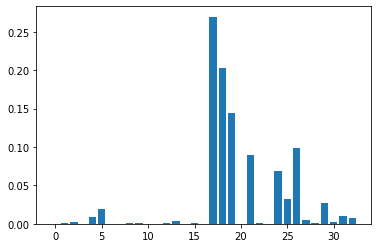

In [24]:
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

### Vemos los nombres de las variables que aportan mas al modelo.

In [72]:
dataset_2 = pd.DataFrame({'importance': importance, 'col_name': names}).sort_values(by='importance',ascending=False)
dataset_3 = dataset_2[dataset_2['importance']>=0.07]
dataset_3['importance'] = pd.Series(["{0:.0f}%".format(val * 100) for val in dataset_3['importance']], index = dataset_3.index)
dataset_3

/Users/yedam/.pyenv/versions/3.7.4/envs/itam_intro_to_ds/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,importance,col_name
17,27%,URGENCIAS MEDICAS
18,20%,FALSA ALARMA
19,14%,DELITO
26,10%,LLAMADA APP911
21,9%,LLAMADA DEL 066
